In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import json
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [11]:

PATH = "/Users/sdutta7/Documents/mlfinalproject/testing_data"
EXT = "*.csv"
all_csv_files = []
for path, subdir, files in os.walk(PATH):
    for file in glob(os.path.join(path, EXT)):
        all_csv_files.append(file)
print(len(all_csv_files))

16


In [10]:

headers = []
with open('config.json') as f:
    headers = json.load(f)
i=0
# df = pd.DataFrame(columns = headers)
fX = []
fy = []
for path in all_csv_files:    
    i+=1
    print("file number- ",i)
    df = pd.read_csv(path,names=headers)
#     df = df.append(df_new, ignore_index = True)
    df['laser_1_180'] = df[['Laser'+str(i+1) for i in range(0,180)]].mean(axis=1)   
    df['laser_181_360'] = df[['Laser'+str(i+1) for i in range(180,360)]].mean(axis=1) 
    df['laser_361_540'] = df[['Laser'+str(i+1) for i in range(360,540)]].mean(axis=1)     
    df['laser_541_720'] = df[['Laser'+str(i+1) for i in range(540,720)]].mean(axis=1)  
    df['laser_721_900'] = df[['Laser'+str(i+1) for i in range(720,900)]].mean(axis=1)  
    df['laser_901_1080'] = df[['Laser'+str(i+1) for i in range(900,1080)]].mean(axis=1)  

    df = df.iloc[: , 1080:]
    X = df[["Final_goal_x","Final_goal_y","Final_goal_qk","Final_goal_qr",
            "Local_goal_x","Local_goal_y","Local_goal_qk","Local_goal_qr",
            "Robot_pos_x","Robot_pos_y","Robot_pos_qr","Robot_pos_qk",
            "laser_1_180","laser_181_360",
            "laser_361_540","laser_541_720",
            "laser_721_900","laser_901_1080"]]
    
    y = df[["Cmd_vel_v","Cmd_vel_w"]]
    X = np.array(X)
    y = np.array(y)
#   # due to large number of data load a Dataframe from csv process it and stor ein numpy array 
    if i>1:
        X_prev = np.load('X_nn.npy')
        y_prev = np.load('y_nn.npy')
        X = np.vstack((X_prev, X))
        y = np.vstack((y_prev, y))
        print("inside concatenate - ", X.shape,y.shape)
        np.save('X_nn.npy', X)   
        np.save('y_nn.npy', y)  
    else:
        np.save('X_nn.npy', X)  
        np.save('y_nn.npy', y)  
    
    


i -  1
 ----<>  0.44548277777777756 17.052938888888885
(23755, 18) (23755, 2)
i -  2
 ----<>  0.44548277777777756 17.052938888888885
(24965, 18) (24965, 2)
i -  3
 ----<>  0.44548277777777756 17.052938888888885
(34855, 18) (34855, 2)
i -  4
 ----<>  0.44548277777777756 17.052938888888885
(25933, 18) (25933, 2)
i -  5
 ----<>  0.44548277777777756 17.052938888888885
(28378, 18) (28378, 2)
i -  6
 ----<>  0.44548277777777756 17.052938888888885
(25384, 18) (25384, 2)
i -  7
 ----<>  0.346762611111111 17.052938888888885
(34641, 18) (34641, 2)
i -  8
 ----<>  0.346762611111111 17.081505555555555
(26785, 18) (26785, 2)
i -  9
 ----<>  0.346762611111111 17.081505555555555
(31538, 18) (31538, 2)
i -  10
 ----<>  0.346762611111111 17.081505555555555
(24045, 18) (24045, 2)
i -  11
 ----<>  0.346762611111111 17.081505555555555
(80633, 18) (80633, 2)
i -  12
 ----<>  0.346762611111111 17.081505555555555
(23961, 18) (23961, 2)
i -  13
 ----<>  0.346762611111111 17.081505555555555
(37573, 18) (37573,

In [9]:

from sklearn.model_selection import train_test_split
X, XValidation, y, yValidation = train_test_split(X,y,test_size=0.2,random_state=42) # before model building
print(X.shape,y.shape,XValidation.shape,yValidation.shape)
np.save('X_train_nn.npy', X)    # .npy extension is added if not given
np.save('y_train_nn.npy', y)  
np.save('X_validation_nn.npy', XValidation)    # .npy extension is added if not given
np.save('y_validation_nn.npy', yValidation)  

(2195595, 18) (2195595, 2) (548899, 18) (548899, 2)


In [18]:
# define the keras model
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=2,
                                            max_value=18,
                                            step=8),
                               activation='relu'))
    model.add(layers.Dense(2, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [0.1,1e-2, 1e-3])),
        loss='mse',
        metrics=['mse'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=2,
    executions_per_trial=3,
    directory='project',
    project_name='Neural Networks for Robot_v4')


# model_neural = Sequential()
# model_neural.add(Dense(12, input_dim=21, activation='relu'))
# model_neural.add(Dense(8, activation='relu'))
# model_neural.add(Dense(2, activation='sigmoid'))
# model_neural.compile(optimizer='adam',
#               loss='mse',
#               metrics=['accuracy','mse',])

In [22]:
print(X.shape,y.shape)
# history = model_neural.fit(X, y, batch_size=100,validation_data=(XValidation,yValidation),epochs=10)
# pickle.dump(model_neural, open('finalized_robot_nural.sav', 'wb')) 
X_training, hej,y_training,bedke =  train_test_split(X,y,test_size=0.6,random_state=42)
XValidation_t,fhjvb,yValidation_t,cbhbc = train_test_split(XValidation,yValidation,test_size=0.6,random_state=42)
print(X_training.shape, y_training.shape,XValidation_t.shape,yValidation_t.shape)
tuner.search(X_training, y_training,
             epochs=4,
             validation_data=(XValidation_t,yValidation_t))

Trial 5 Complete [00h 07m 23s]
val_mse: 0.05177746464808782

Best val_mse So Far: 0.05177746464808782
Total elapsed time: 00h 22m 46s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.results_summary()

Results summary
Results in project/Neural Networks for Robot_v3
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
num_layers: 4
units_0: 8
units_1: 16
learning_rate: 0.01
units_2: 24
units_3: 8
units_4: 8
Score: 0.05177746464808782
Trial summary
Hyperparameters:
num_layers: 5
units_0: 8
units_1: 32
learning_rate: 0.01
units_2: 8
units_3: 8
units_4: 8
Score: 0.05220899855097135


In [45]:
best_hps = tuner.get_best_hyperparameters()[0]
model_v1 = tuner.hypermodel.build(best_hps)
history_v1 = model_v1.fit(X, y, epochs=5)
model_v1 = tuner.hypermodel.build(best_hps)
history_validate_v1 = model_v1.fit(XValidation,yValidation, epochs=5)
# validation_data=(XValidation,yValidation)

Epoch 1/5
3588/3588 [==============================] - 14s 4ms/step - loss: 0.1135 - mean_absolute_error: 0.1135
Epoch 2/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0978 - mean_absolute_error: 0.0978
Epoch 3/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0932 - mean_absolute_error: 0.0932
Epoch 4/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0884 - mean_absolute_error: 0.0884
Epoch 5/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0852 - mean_absolute_error: 0.0852
Epoch 1/5
897/897 [==============================] - 4s 4ms/step - loss: 0.1360 - mean_absolute_error: 0.1360
Epoch 2/5
897/897 [==============================] - 3s 4ms/step - loss: 0.1112 - mean_absolute_error: 0.1112
Epoch 3/5
897/897 [==============================] - 3s 4ms/step - loss: 0.1056 - mean_absolute_error: 0.1056
Epoch 4/5
897/897 [==============================] - 3s 4ms/step - loss: 0.1030 - mean_absolute_error: 0.

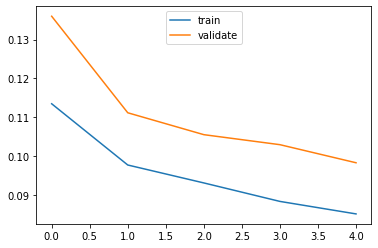

In [55]:
# plot metrics

from matplotlib import pyplot
pyplot.plot(history_v1.history['mean_absolute_error'],label="train")
pyplot.plot(history_validate_v1.history['mean_absolute_error'],label="validate")
pyplot.legend(loc='upper center')
# pyplot.plot(history.history['accuracy'])
pyplot.show()

In [ ]:
#performance 
